In [2]:
import sys
sys.path.insert(1, '..\\')
from utils import *

%matplotlib inline

In [4]:
with open(join('..', '..', 'config.yml')) as f:
    config = yaml.safe_load(f)
    
pwd = config['pwd']
dpath = config['storage']
patterns = config['pattern-data-path']
util_datasets = config['util_datasets']
datasets = config['datasets']
FIG_SAVE_DIR = join(pwd, 'figures')
RESULT_SAVE_DIR = join(pwd, 'results')

AREA_NAME = 'NYC'

In [5]:
nyc_county_fips = {
    36085: 'Staten Island',
    36061: 'Manhattan',
    36005: 'Bronx',
    36081: 'Queens',
    36047: 'Brooklyn'
}

gmob_report = pd.read_csv(join(pwd, 'util_datasets', 'google-mobility-report-2020.csv'))
gmob_report = gmob_report.dropna(subset=['census_fips_code'])
gmob_report.census_fips_code = gmob_report.census_fips_code.astype(np.int32)
gmob_report = gmob_report[gmob_report['census_fips_code'].isin(set(nyc_county_fips.keys()))]
gmob_report.date = pd.to_datetime(gmob_report.date)

In [6]:
gmob_report.columns

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

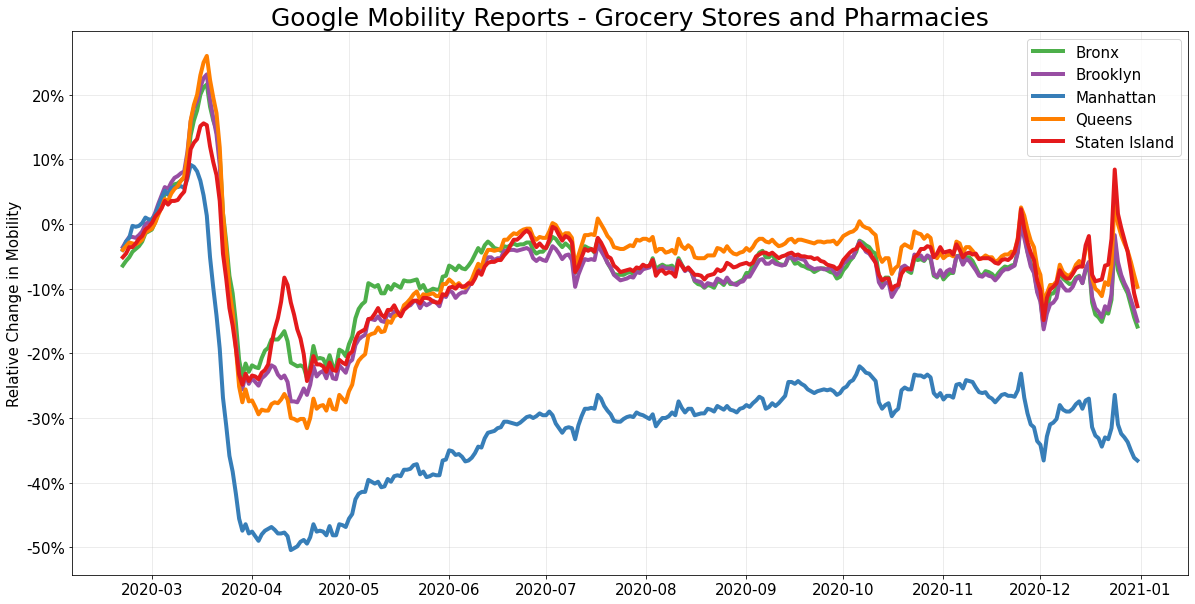

In [23]:
fig, ax = plt.subplots(1,1,figsize=(20, 10))

borough_colors = {
    'Staten Island': '#e41a1c',
    'Manhattan': '#377eb8',
    'Bronx': '#4daf4a',
    'Brooklyn': '#984ea3',
    'Queens': '#ff7f00'
}

for code, ind in gmob_report.groupby('census_fips_code').groups.items():
    series = gmob_report.loc[ind, ['date', 'grocery_and_pharmacy_percent_change_from_baseline']].set_index('date').sort_index()
    series = series.rolling(7).mean()
    ax.plot(series.index, series.values, label=nyc_county_fips[code], linewidth=4, color=borough_colors[nyc_county_fips[code]])
    
ax.legend(prop={'size': 15})
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.0f}%'))
ax.grid(color='#bdbdbd', alpha=0.35)
ax.set_ylabel('Relative Change in Mobility', fontsize=15)
ax.set_title('Google Mobility Reports - Grocery Stores and Pharmacies', fontsize=25)
fig.savefig(join(FIG_SAVE_DIR, 'google-report-2020.pdf'), dpi=150)

In [33]:
nyc_geojson = join(pwd, 'util_datasets', AREA_NAME, f'{AREA_NAME}-cbgs.json')
base_df = gpd.read_file(nyc_geojson)
base_df = base_df[base_df.BLKGRPCE != '0']
base_df = base_df[['GEOID', 'geometry']]
base_df.GEOID = pd.to_numeric(base_df.GEOID)
base_df = base_df.dissolve(by='GEOID')

In [34]:
msa_counties = pd.read_csv(join(pwd, util_datasets, AREA_NAME, datasets['nyc-msa']))['fips'].astype(np.int64)

In [35]:
census_data = join(pwd, util_datasets, datasets['census-data'])
census_quartiles, census_raw = get_census_attributes(census_data, msa_counties)

In [36]:
ct_populations = census_raw.groupby(census_raw.census_block_group)['total_population'].sum()

In [37]:
essential_sub_categories = pd.read_csv(join(pwd, 'util_datasets', 'sub_categories.csv'))
essential_sub_categories = essential_sub_categories[essential_sub_categories.is_essential == 1]['category'].values

In [38]:
def poi_diversity(pois, richness=False):
    pois = pois[~pois.isna()]
    if pois.shape[0] == 0:
        return -1
    
    value, counts = np.unique(pois.values, return_counts=True)
    total = counts.sum()
    
    e = 0
    for c in counts:
        p = c / total
        e += -p * np.log(p)
    e = np.exp(e)  #/ np.log2(len(counts))
    
    if richness:
        e = len(value)
    
    return e 

In [39]:
def poi_counts(pois):
    pois = pois[~pois.isna()]
    if pois.shape[0] == 0:
        return -1
    
    return pois.shape[0]

In [40]:
bdir = join(pwd, dpath, 'area-pois', AREA_NAME)

dfs = []
for f in os.listdir(bdir):
    dfs.append(pd.read_csv(join(bdir, f)))

In [41]:
df = pd.concat(dfs, axis=0)
df.drop('index_right', inplace=True, axis=1)
df = df.drop_duplicates(subset=['safegraph_place_id'])
df = df[df.sub_category.isin(essential_sub_categories)]

In [42]:
df.groupby(df.GEOID.astype(str).apply(lambda x: x[:5])).size()

GEOID
34003    13083
34013     8621
34017     7080
34019     1850
34023     9059
34025     9004
34027     6766
34029     6080
34031     5464
34035     4228
34037     1748
34039     6293
36005     8205
36047    22235
36059    17360
36061    30876
36079     1078
36081    18208
36085     4164
36087     3449
36103    18909
36119    12186
42103      546
dtype: int64

In [540]:
# poi_locs = np.radians(df[['latitude', 'longitude']].values)

# # haversine dist to km
# h2km = 6371
# btree = BallTree(poi_locs, metric='haversine')

# centroids = base_df.geometry.centroid
# lon = centroids.x
# lat = centroids.y
# cbg_locs = np.radians(pd.concat([lat, lon], axis=1).values)

# radius_in_km = 1
# poi_indices = btree.query_radius(cbg_locs, r=radius_in_km/h2km)

# poi_count_diversity = []
# for pi in tqdm(poi_indices):
#     poi_cats = df.iloc[pi]['top_category']
#     poi_count_diversity.append({
#         'poi_count': poi_counts(poi_cats),
#         'poi_diversity': poi_diversity(poi_cats)
#     })
    
# poi_features = pd.concat([base_df[['GEOID']].reset_index(drop=True), pd.DataFrame(poi_count_diversity)], axis=1)
# poi_features.GEOID = pd.to_numeric(poi_features.GEOID)

In [43]:
merged_census_tracts = gpd.sjoin(base_df, gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude)), how='inner', op='contains')

In [44]:
merged_census_tracts.head()

,geometry,index_right,safegraph_place_id,top_category,sub_category,latitude,longitude,GEOID
GEOID,,,,,,,,
360050001001,"POLYGON ((-73.87425 40.79232, -73.87107 40.788...",92499,sg:095f91a108454ea7a8babeb79b96b97e,"Justice, Public Order, and Safety Activities",Correctional Institutions,40.789077,-73.873667,36005
360050001001,"POLYGON ((-73.87425 40.79232, -73.87107 40.788...",55167,sg:e029b12d75cb4fabaddb552c68951ca2,Medical and Diagnostic Laboratories,Medical Laboratories,40.788980,-73.882136,36005
360050001001,"POLYGON ((-73.87425 40.79232, -73.87107 40.788...",93163,sg:37a912bca48a4f919ba044a17d339a50,"Justice, Public Order, and Safety Activities",Correctional Institutions,40.789302,-73.881461,36005
360050001001,"POLYGON ((-73.87425 40.79232, -73.87107 40.788...",93997,sg:a09007d34fce49208fcb8287d31d6ae9,"Justice, Public Order, and Safety Activities",Correctional Institutions,40.789322,-73.886152,36005
360050001001,"POLYGON ((-73.87425 40.79232, -73.87107 40.788...",92462,sg:4ccd08b98dd947918f47136c29b1fb30,"Justice, Public Order, and Safety Activities",Correctional Institutions,40.790781,-73.877117,36005


In [45]:
rows = []

for census_tract in np.unique(merged_census_tracts.index):
    categories = merged_census_tracts.loc[census_tract, ['top_category']]
    pcount = poi_counts(categories)
    diversity = poi_diversity(categories, richness=True)
    rows.append({
        'census_tract': census_tract,
        'population': ct_populations[census_tract],
        'poi_count': pcount,
        'poi_diversity': diversity,
        'poi_per_capita': (pcount + 1e-8) / ct_populations[census_tract] if ct_populations[census_tract] > 0 else 1e-8
    })
    
ctracts = gpd.GeoDataFrame(rows)

In [46]:
ctracts.to_csv(join(pwd, util_datasets, 'nyc-cbg-poi-info.csv'), index=False)

In [575]:
# merged_features = pd.merge(census_raw_values, poi_features, left_on='census_block_group', right_on='GEOID', how='inner')
# merged_features = merged_features[['census_block_group', 'income', 'white_population', 'education', 'mean_time_to_work', 'poi_count', 'poi_diversity']].dropna().reset_index(drop=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.47it/s]


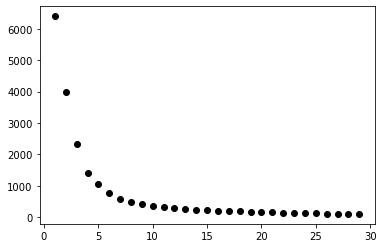

In [604]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cluster = KMeans(10, random_state=0)
features = ctracts[['poi_count', 'poi_per_capita', 'poi_diversity']].values
standardized_features = scaler.fit_transform(features)

K = np.arange(1, 30)
sse = []
for k in tqdm(K):
    cluster = KMeans(k, random_state=0)
    result = cluster.fit(standardized_features)
    sse.append(result.inertia_)
    
plt.plot(K, sse, 'ko')

In [613]:
cluster = KMeans(5, random_state=0)
result = cluster.fit(standardized_features)

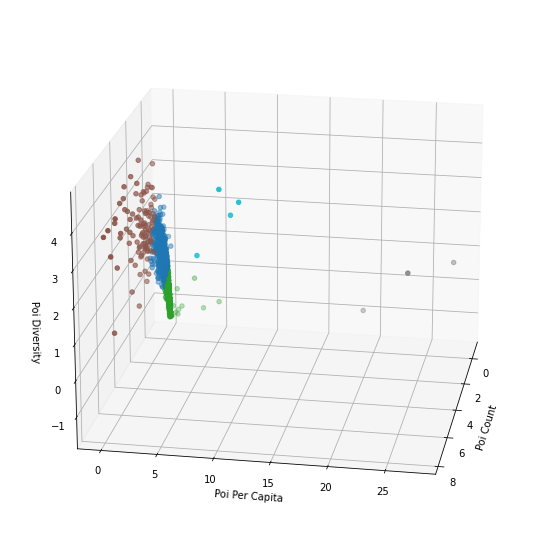

In [618]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection='3d')

ax.scatter(standardized_features[:, 0], standardized_features[:, 1], standardized_features[:, 2], 'gray', c=result.labels_, cmap='tab10')
ax.set_xlabel('Poi Count')
ax.set_ylabel('Poi Per Capita')
ax.set_zlabel('Poi Diversity');
ax.view_init(20, 10)

<AxesSubplot:>

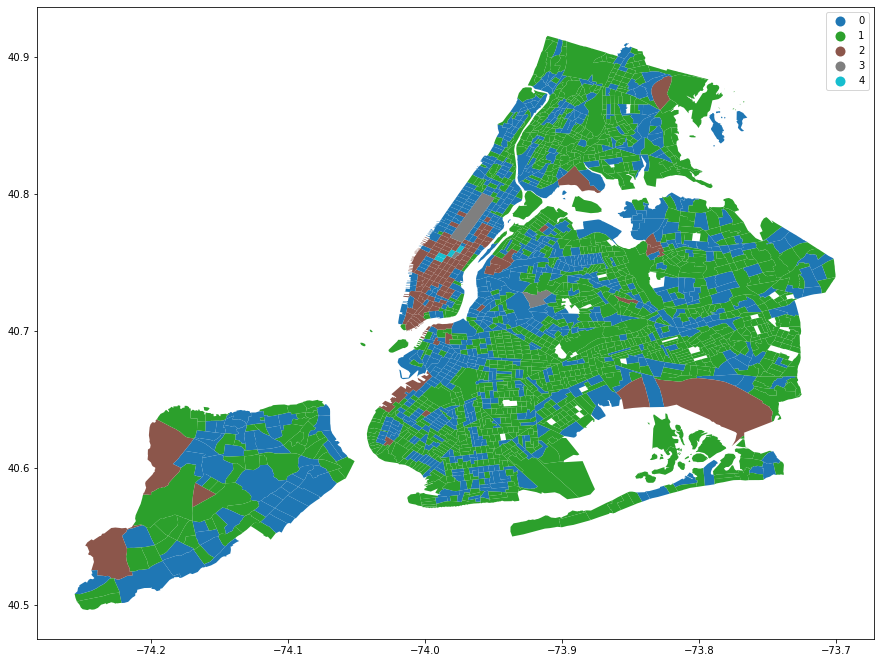

In [615]:
ctracts['clabels'] = result.labels_
fig, ax = plt.subplots(1,1,figsize=(15, 15))
ctracts.plot(column='clabels', categorical=True, legend=True, ax=ax, cmap='tab10')

In [466]:
# clabels = result.labels_
# merged_features['clusters'] = pd.Series(clabels)
# res = pd.merge(merged_features, base_df, left_on='census_block_group', right_on='GEOID', how='inner')

# fig, ax = plt.subplots(1,1,figsize=(15, 15))
# gpd.GeoDataFrame(res).plot(column='clusters', legend=True, figsize=(15, 15), cmap='tab10', categorical=True, ax=ax)
# ax.axis('off')
# fig.savefig(join(FIG_SAVE_DIR, 'clusters.png'));